In [ ]:
import torch
import torch.nn as nn
import time
import numpy as np
import copy
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.integrate import solve_ivp
!pip install tikzplotlib #uncomment for saving nice images
import tikzplotlib
from pylab import *
# set precision
torch.set_default_dtype(torch.float64)
print('Default data type:', torch.get_default_dtype())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Default data type: torch.float64


In [ ]:
!pip install hessquik
import hessQuik.activations as act
import hessQuik.layers as lay
import hessQuik.networks as net
from hessQuik.utils import  test
#from hessQuik.utils import print_headers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Create training, validation, and testing sets

In [ ]:
'''
Create training, validation, and testing sets
  - Loading the dataset, formatting our data, and determining step size

'''


n_train = 2000      # number of training points
n_val = 300         # number of validation points
n_test = 300        # number of testing points

#import data and assign each array to a different value
from pathlib import Path
odeDataPath = Path('sho_data.npz') #path to file
odeData = np.load(odeDataPath)


#these are the tensors of our data
print(odeData['y'])
yData = np.reshape(odeData['y'],[-1,1]) #reshape the data so its [datapoints x 1] tensor
zData = np.reshape(odeData['z'],[-1,1])
tData = np.reshape(odeData['t'],[-1,1])

# assign data to x and y
x = np.concatenate([tData,yData,zData],axis=1) #combine the y and z data 
x = torch.tensor(x)
y = np.concatenate([yData,zData],axis =1 )
y = torch.tensor(y)

# no shuffling
n_samples = n_train
x_train, y_train = x[:n_train], y[1:n_train+1]
x_val, y_val = x_train[3:17], y_train[3:17]
x_test, y_test = x_train[7:28], y_train[7:28]

#print(x_train.size()) #[2000, 3]
#print(y_train.size()) #[2000, 2]

# shuffle and split data
# idx = torch.randperm(n_train + n_val + n_test)
# x_train, y_train = x[idx[:n_train]], y[idx[:n_train]]
# x_val, y_val = x[idx[n_train:n_train + n_val]], y[idx[n_train:n_train + n_val]]
# x_test, y_test = x[idx[n_train + n_val:]], y[idx[n_train + n_val:]]

stepSize = (x_train[1,0] - x_train[0,0])
#print("stepsize=", stepSize)

[0.         0.00750186 0.01500361 ... 1.30513066 1.29943373 1.29371898]


Network Architecture

In [ ]:
'''
Create our Network:
  - our width and depth, as well as the function we use to create our ResNet

'''

width = 20
depth = 3
f = net.NN(lay.singleLayer(3, width, act=act.tanhActivation()),
           net.resnetNN(width, depth, h=0.5, act=act.tanhActivation()),
           lay.singleLayer(width, 1, act=act.identityActivation()))

# Pytorch optimizer for the network weights:
optimizer = torch.optim.Adam(f.parameters(), lr=1e-3) 
#weight decay is for regularization, add weight_decay=1e-5 


Loss

In [ ]:
#Our Mean Squared Error Loss Function
def mse_loss(y_true: torch.Tensor,y: torch.Tensor):
  return (0.5 / y.shape[0]) * torch.norm(y_true - y.view_as(y_true)) ** 2

In [ ]:
#A function for printing the various headers necessary for seeing our network running
def print_headers( verbose: bool = True):
    r"""
    Print headers for nice training
    """
    loss_printouts = ('loss',)
    n_loss = len(loss_printouts)

    headers = (('', '', '|', 'running',) + (n_loss - 1) * ('',) + ('|', 'train',)
               + (n_loss - 1) * ('',) + ('|', 'valid',) + (n_loss - 1) * ('',))

    printouts = ('epoch', 'time') + 3 * (('|',) + loss_printouts)
    printouts_frmt = '{:<15d}{:<15.4f}' + 3 * ('{:<2s}' + n_loss * '{:<15.4e}')

    if verbose:
        print(('{:<15s}{:<15s}' + 3 * ('{:<2s}' + n_loss * '{:<15s}')).format(*headers))
        print(('{:<15s}{:<15s}' + 3 * ('{:<2s}' + n_loss * '{:<15s}')).format(*printouts))

    return headers, printouts, printouts_frmt

Training

                              | running        | train          | valid          
epoch          time           | loss           | loss           | loss           
0              0.0874         | 2.7838e-05     | 2.7529e-05     | 3.5762e-05     
5              0.0498         | 2.6345e-05     | 2.6059e-05     | 3.2501e-05     
10             0.0461         | 2.4941e-05     | 2.4666e-05     | 2.9747e-05     
15             0.0470         | 2.3566e-05     | 2.3290e-05     | 2.7400e-05     
20             0.0439         | 2.2179e-05     | 2.1898e-05     | 2.5354e-05     
25             0.0452         | 2.0761e-05     | 2.0473e-05     | 2.3508e-05     
30             0.0642         | 1.9307e-05     | 1.9012e-05     | 2.1776e-05     
35             0.0600         | 1.7815e-05     | 1.7512e-05     | 2.0098e-05     
40             0.0746         | 1.6284e-05     | 1.5974e-05     | 1.8443e-05     
45             0.0815         | 1.4720e-05     | 1.4403e-05     | 1.6813e-05     
50             0

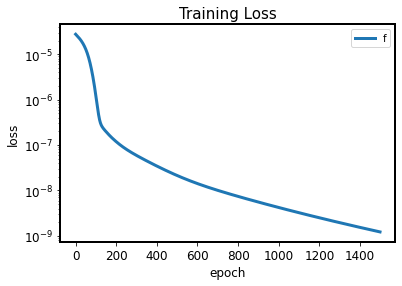

In [ ]:
'''
Training our Network
  - Print the table detailing various losses over epochs, and produce a figure 
    showing the training loss as the epochs go on.

'''

# training parameters
max_epochs = 1500
batch_size = n_samples

# get printouts
headers, printouts_str, printouts_frmt = print_headers()

# ---------------------------------------------------------------------------- #
# initial evaluation
# mse_loss = nn.MSELoss()
f_train = f(x_train,do_gradient=True,do_hessian = False) #our net for training

fy = ((f_train[1])[:,1,:]) #The y data from our net
fz = ((f_train[1])[:,2,:]) #the z data from our net

yTimeOne = stepSize*fz  + x_train[:,1:2] 
zTimeOne = -1 * stepSize*fy + x_train[:,2:3]

#loss_train = mse_loss(torch.cat((yTimeOne,zTimeOne),dim=1),y_train)


# ---------------------------------------------------------------------------- #
#now construct the neural nets for validation
f_val = f(x_val,do_gradient=True,do_hessian = False) #our net for validation

fy = ((f_val[1])[:,1,:]) #The y data from our net
fz = ((f_val[1])[:,2,:]) #the z data from our net

yTimeOneVal = stepSize*fz  + x_val[:,1:2]
zTimeOneVal = -1 * stepSize*fz + x_val[:,2:3]

#loss_val = mse_loss(torch.cat((yTimeOneVal,zTimeOneVal),dim=1),y_val)


#For printing: 
his_iter = (-1, 0.0) + ('|',) + (0,) + ('|',) + (0,) + ('|',) + (0,)
# print(printouts_frmt.format(*his_iter))

# store history
his = np.array([x for x in his_iter if not (x == '|')]).reshape(1, -1)

# ---------------------------------------------------------------------------- #
# main iteration

log_interval = 5 # how often printouts appear

for epoch in range(max_epochs):
    t0 = time.perf_counter()
    # training here
    f.train()
    n = x_train.shape[0]
    b = batch_size
    n_batch = n // b
    loss = torch.zeros(1)
    running_loss = 0.0

    # shuffle
    idx = torch.randperm(n) #identity?

    for i in range(n_batch):
        idxb = idx[i * b:(i + 1) * b] #random permute based on batch number
        xb, yb = x_train[idxb], y_train[idxb] #get that batch data
        optimizer.zero_grad()
        f_batch= f(xb,do_gradient=True,do_hessian = False) 
        #print(f_batch)
        fby = ((f_batch[1])[:,1,:]) #y from the batch
        fbz = ((f_batch[1])[:,2,:]) #z from the batch
        
        # unstable?     -> huh?
        #do verlet once to the first time step
        yTimeOneVal = stepSize*fbz  + xb[:,1:2]
        zTimeOneVal = -1 * stepSize*fby + xb[:,2:3]

        # stable
        # yTimeOneVal = stepSize*fb2  + xb[:,1:2]
        # zTimeOneVal = -1 * stepSize*yTimeOneVal + xb[:,2:3] # think about higher order verlet
        loss = mse_loss(torch.cat((yTimeOneVal,zTimeOneVal),dim=1),yb)
        running_loss += b * loss.item()

        # update network weights
        loss.backward(retain_graph=True)
        optimizer.step()

    running_loss = (running_loss / n,)
    
    t1 = time.perf_counter()

    # test
    fc_train= f(x_train,do_gradient=True,do_hessian = False) #training

    yTimeOneVal = stepSize*fc_train[1][:,2,:].detach()  + x_train[:,1:2]
    zTimeOneVal = -1 * stepSize*fc_train[1][:,1,:].detach() + x_train[:,2:3]

    loss_train = mse_loss(torch.cat((yTimeOneVal,zTimeOneVal),dim=1),y_train)

    fc_val= f(x_val,do_gradient=True,do_hessian = False) #validation

    yTimeOneVal = stepSize*fc_val[1][:,2,:].detach()  + x_val[:,1:2]
    zTimeOneVal = -1 * stepSize*fc_val[1][:,1,:].detach() + x_val[:,2:3]

    loss_val = mse_loss(torch.cat((yTimeOneVal,zTimeOneVal),dim=1),y_val)

    t = t1-t0
    his_iter = (epoch, t1 - t0) + ('|',) + running_loss + ('|',) + (loss_train.item(),) + ('|',) + (loss_val.item(),)
    if epoch % log_interval == 0:
      print(printouts_frmt.format(*his_iter))

    # store history
    idx = [idx for idx, n in enumerate(np.array([x for x in printouts_str if not (x == '|')])) if n == 'loss'][1]
    his = np.concatenate((his, np.array([x for x in his_iter if not (x == '|')]).reshape(1, -1)), axis=0)

# ---------------------------------------------------------------------------- #
# overall performance on test data
f_test= f(x_test,do_gradient=True,do_hessian = False)

yTimeOneVal = stepSize*f_test[1][:,2,:].detach()  + x_test[:,1:2]
zTimeOneVal = -1 * stepSize*f_test[1][:,1,:].detach() + x_test[:,2:3]

loss_test = mse_loss(torch.cat((yTimeOneVal,zTimeOneVal),dim=1), y_test)
print('Test Loss: %0.4e' % loss.item())



# ---------------------------------------------------------------------------- #
# convergence plot

rc('axes', linewidth=2)
fig = plt.figure()
linewidth = 3

idx = [idx for idx, n in enumerate(np.array([x for x in printouts_str if not (x == '|')])) if n == 'loss'][1]

plt.semilogy(his[1::, 0], his[1::, idx], linewidth=linewidth, label='f')

#labels and legens
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.title('Training Loss', fontsize=15) 
plt.legend()

#set label text size
ax = gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)


plt.show()
#fig.savefig('Training Loss.png',dpi=600) #to save the image w/ high dpi

Overall Performance

In [ ]:
# overall performance on test data
f_test= f(x_test,do_gradient=True,do_hessian = False) 

fy = ((f_test[1])[:,1,:])
fz = ((f_test[1])[:,2,:])

yTimeOneVal = stepSize*fz  + x_test[:,1:2]
zTimeOneVal = -1 * stepSize*yTimeOneVal + x_test[:,2:3]

loss_test = mse_loss(torch.cat((yTimeOneVal,zTimeOneVal),dim=1), y_test)
print('Test Loss: %0.4e' % loss.item())

Test Loss: 1.2241e-09


Continuous Train of Model

In [ ]:
# Go back and solve the ODE, put info in sol array

t, y, z = x_train[0:1,0:1], x_train[0:1,1:2], x_train[0:1,2:3] 

steps = n_samples
h = stepSize
sol = torch.zeros(steps,4)

for i in range(steps):
  f_solve = f(torch.cat((t,y,z),dim=1),do_gradient=True,do_hessian = False) 

  f1 = f_solve[1][:,1:2,0].detach()
  f2 = f_solve[1][:,2:3,0].detach()

  y = h*f2  + y
  z = -1 * h*f1 + z
  t = t + h
  sol[i:i+1,:] =  torch.cat((t,y,z,f_solve[0].detach()),dim=1)



True Y True Z vs Learned Y and Learned Z 

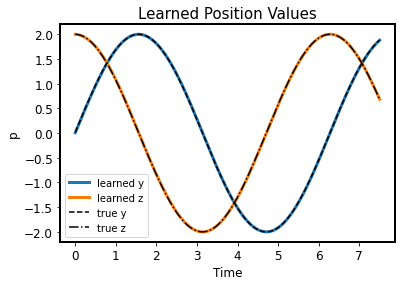

In [ ]:
#Here we are plotting our learned y and z against the true y and z

t, y, z = x_train[0:1,0:1], x_train[0:1,1:2], x_train[0:1,2:3] 

steps = n_samples
h = stepSize
sol = torch.zeros(steps,4)

for i in range(steps):
  fb = f(torch.cat((t,y,z),dim=1),do_gradient=True,do_hessian = False) 
  fb1 = fb[1][:,1:2,0].detach()
  fb2 = fb[1][:,2:3,0].detach()
  y = h*fb2  + y
  z = -1 * h*fb1 + z
  t = t + h
  sol[i:i+1,:] =  torch.cat((t,y,z,fb[0].detach()),dim=1)


rc('axes', linewidth=2)
fig = plt.figure()

#lines
plt.plot(sol[:,0].detach().numpy(),sol[:,1].detach().numpy(), linewidth=3)
plt.plot(sol[:,0].detach().numpy(),sol[:,2].detach().numpy(), linewidth=3)
plt.plot(x_train[1:steps,0].detach().numpy(),y_train[1:steps:,0].detach().numpy(),"k--")
plt.plot(x_train[1:steps,0].detach().numpy(),y_train[1:steps:,1].detach().numpy(),"k-.")

#labels
plt.title("Learned Position Values", fontsize=15)
plt.ylabel("p", fontsize=12)
plt.xlabel("Time", fontsize=12)
plt.legend(['learned y','learned z','true y', 'true z'])

ax = gca()
#set label text size
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)


fig.savefig('Learned Position Values.png',dpi=600, bbox_inches = 'tight', pad_inches = 0.05) #to save the image

Plotting Relationship between p and q

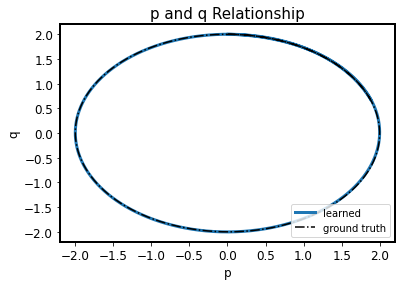

In [ ]:
#Here we are plotting the learned p and q

rc('axes', linewidth=2)
fig = plt.figure()

#lines
plt.plot(sol[:,1],sol[:,2], linewidth=3)
plt.plot(x_train[1:steps,1],y_train[1:steps:,1],"k-.")

#labels and legend
plt.legend(['learned','ground truth'], loc="lower right")
plt.title("p and q Relationship", fontsize=15)
plt.xlabel("p", fontsize=12)
plt.ylabel("q", fontsize=12)


ax = gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)


plt.show()

fig.savefig('p and q.png',dpi=600, bbox_inches = 'tight', pad_inches = 0.05) #to save the image

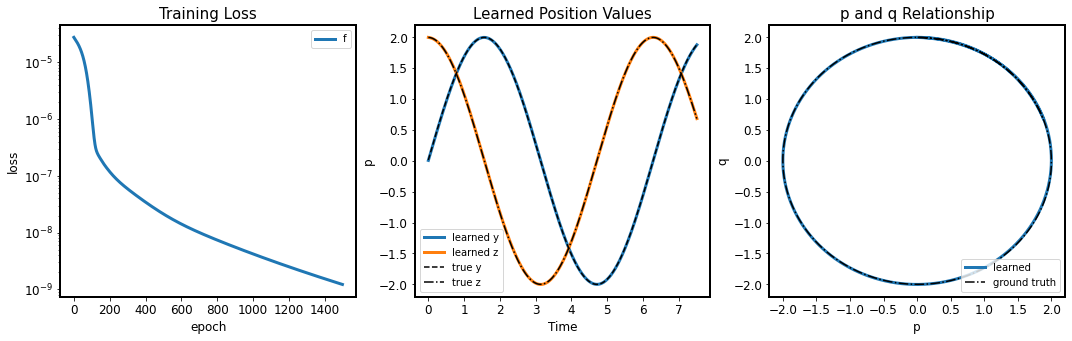

In [ ]:
'''
All Three Figures in One Rectangle
  - Edit the sizing for scaling, and add or remove whitspace with pad_inches

'''


# convergence plot
rc('axes', linewidth=2)

fig = plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
linewidth = 3

idx = [idx for idx, n in enumerate(np.array([x for x in printouts_str if not (x == '|')])) if n == 'loss'][1]

plt.semilogy(his[1::, 0], his[1::, idx], linewidth=linewidth, label='f')

plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.title('Training Loss', fontsize=15) 
plt.legend()

ax = gca()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)



#learned y and z against the true y and z

rc('axes', linewidth=2)

t, y, z = x_train[0:1,0:1], x_train[0:1,1:2], x_train[0:1,2:3] 
steps = n_samples
h = stepSize
sol = torch.zeros(steps,4)

for i in range(steps):
  fb = f(torch.cat((t,y,z),dim=1),do_gradient=True,do_hessian = False) #again fb?
  fb1 = fb[1][:,1:2,0].detach()
  fb2 = fb[1][:,2:3,0].detach()
  y = h*fb2  + y
  z = -1 * h*fb1 + z
  t = t + h
  sol[i:i+1,:] =  torch.cat((t,y,z,fb[0].detach()),dim=1)

plt.subplot(1, 3, 2)

plt.plot(sol[:,0].detach().numpy(),sol[:,1].detach().numpy(), linewidth=3)
plt.plot(sol[:,0].detach().numpy(),sol[:,2].detach().numpy(), linewidth=3)
plt.plot(x_train[1:steps,0].detach().numpy(),y_train[1:steps:,0].detach().numpy(),"k--")
plt.plot(x_train[1:steps,0].detach().numpy(),y_train[1:steps:,1].detach().numpy(),"k-.")

plt.title("Learned Position Values", fontsize=15)
plt.ylabel("p", fontsize=12)
plt.xlabel("Time", fontsize=12)
plt.legend(['learned y','learned z','true y', 'true z'])

ax = gca()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)


#p and q relationship
plt.subplot(1, 3, 3)
rc('axes', linewidth=2)

plt.plot(sol[:,1],sol[:,2], linewidth=3)
plt.plot(x_train[1:steps,1],y_train[1:steps:,1],"k-.")

plt.legend(['learned','ground truth'], loc="lower right")
plt.title("p and q Relationship", fontsize=15)
plt.xlabel("p", fontsize=12)
plt.ylabel("q", fontsize=12)

ax = gca()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(12)



fig.savefig('findingNemo.png',dpi=600, bbox_inches = 'tight', pad_inches = 0.05) #to save the image